<a href="https://colab.research.google.com/github/prometneus/Nonribosomal-Peptides/blob/main/NonRibosomalPeptides_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install catboost

In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import catboost

from matplotlib import pyplot as plt
# %matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [36]:
!wget https://raw.githubusercontent.com/prometneus/Nonribosomal-Peptides/main/data/FullDB.csv

--2021-07-09 22:06:45--  https://raw.githubusercontent.com/prometneus/Nonribosomal-Peptides/main/data/FullDB.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612651 (598K) [text/plain]
Saving to: ‘FullDB.csv.2’

FullDB.csv.2        100%[===================>] 598.29K  --.-KB/s    in 0.05s   

2021-07-09 22:06:46 (13.0 MB/s) - ‘FullDB.csv.2’ saved [612651/612651]



In [37]:
data = pd.read_csv("FullDB.csv")
data.head(10)

,spec,Sequence,8A-signature,stachelhaus-code
0,pro,YRELDERANRLAHLLAAHGVGPERIVALALPRSVDLVVAVLAVLKA...,LWHTFDVSAQESFAAQAGEHNHYGPTETHVVTAH,DVQFAAHVV-
1,pro,TYKELNESANRLARHLRKKGVMRQEPVAIMMERSTEFVTGILGILK...,LFEAFDVCYQESVSITAGEHNHYGPSETHVVSAY,DVQVIAHVV-
2,pro,TYRELHERSNQLARFLREKGVKKESIIGIMMERSVEMIVGILGILK...,LFTTFDVCYQESSFITAGEHNHYGPSETHVVTTY,DVQSIAHVV-
3,pro,SYRRLDQLSSSLAEELIGHGVGVEMTIPVLLEKTCWTPVAMLAVLK...,AHLSWDIPVTDLLLVLAGEIQGYGPAECSLVSTV,DITLVAGLV-
4,pro,TYRELNKAANRLARHLRMKGVVRQEPVAIMMERSAAFITGVLGILK...,LFEAFDVCYQESFLIAAGEHNHYGPSETHVVSTY,DVQFIAHVV-
5,pro,TYRELWAHSSFFARQLQRYGVTRGTPVAVCLDRSRWSIAVILGVLL...,SHHSFDVSIYETFLVLGGEINGYGPAEATICGVG,DVYFVGGIC-
6,pro,TYQQLNQKANQLAHSLQCLGVTPDSLVAICLERSLDMAVAILGTLK...,LHHAFDVSYHEAILITAGEYNFYGPSEADLVTAY,DVHIIAFLV-
7,pro,SYTELERVSSTWARQLQKQGISQGSWVLFCFEKSRLAVVSMIAILK...,AAYSFDISIADTVLIFTGEYNVYGPAENTLITTA,DIAVITVLI-
8,pro,TYSELDRQSDELAGWLRQQRLPAESLVAVLAPRSCQTIVAFLGILK...,VSPTFDVSLWETVFFSSGDHNAYGPTENGIQSTI,DVWVFSAIQ-
9,pro,TYYELNYRANQLAHYLQSLGVGSDALVGLCVERSLEMVIGLLGILK...,LWHAFDVSFQETFLITAGEHNHYGPSESHLATSF,DVQFIAHLA-


In [38]:
data.dropna()
data.isna().sum()

spec                0
Sequence            0
8A-signature        0
stachelhaus-code    0
dtype: int64

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   spec              1354 non-null   object
 1   Sequence          1354 non-null   object
 2   8A-signature      1354 non-null   object
 3   stachelhaus-code  1354 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


In [40]:
# refuse = ['dht', 'dab', 'pip', 'trp', 'ala-b', 'abu', 'ser-thr', 'sal', 'lys-b',
#           'alaninol', 'vol', 'd-lyserg', 'tcl', '3-me-glu', 'dpg', '4ppro',
#           'bmt', 'ala-d', 'aeo', 'hiv', 'his', 'phg', 'spec', 'pip']
# for i, elem in enumerate(refuse):
#   data.drop(data[data['spec'] == refuse[i]].index, inplace=True)

# data.head(10)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   spec              1354 non-null   object
 1   Sequence          1354 non-null   object
 2   8A-signature      1354 non-null   object
 3   stachelhaus-code  1354 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


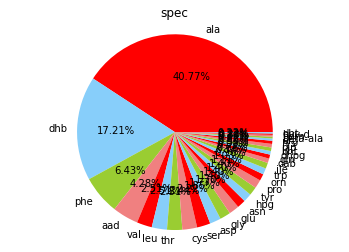

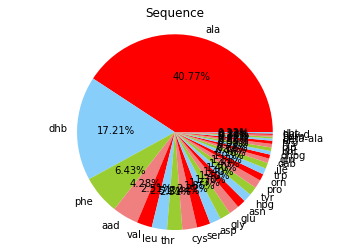

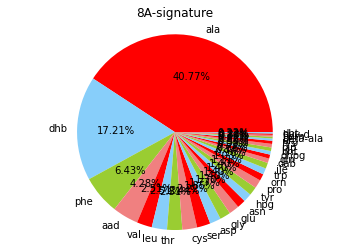

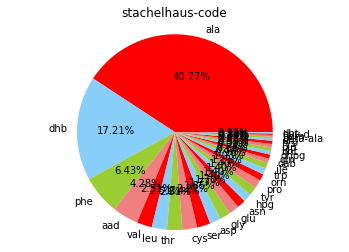

In [42]:
for ctg in data:
  plot,figure = plt.subplots()
  colors = ['red', 'lightskyblue', 'yellowgreen', 'lightcoral']
  lbl = list(data['spec'].value_counts().index)
  figure.pie(data['spec'].value_counts().tolist(),
             colors = colors, labels=lbl,autopct='%1.2f%%')
  figure.axis('equal') 
  figure.set_title(ctg)
  plt.show()

In [43]:
X = data['8A-signature']
y = data['spec']
X.head(10)

0    LWHTFDVSAQESFAAQAGEHNHYGPTETHVVTAH
1    LFEAFDVCYQESVSITAGEHNHYGPSETHVVSAY
2    LFTTFDVCYQESSFITAGEHNHYGPSETHVVTTY
3    AHLSWDIPVTDLLLVLAGEIQGYGPAECSLVSTV
4    LFEAFDVCYQESFLIAAGEHNHYGPSETHVVSTY
5    SHHSFDVSIYETFLVLGGEINGYGPAEATICGVG
6    LHHAFDVSYHEAILITAGEYNFYGPSEADLVTAY
7    AAYSFDISIADTVLIFTGEYNVYGPAENTLITTA
8    VSPTFDVSLWETVFFSSGDHNAYGPTENGIQSTI
9    LWHAFDVSFQETFLITAGEHNHYGPSESHLATSF
Name: 8A-signature, dtype: object

In [44]:
print(pd.unique(y))
print(len(pd.unique(y)))

['pro' 'phe' 'asn' 'gln' 'tyr' 'val' 'orn' 'leu' 'ile' 'cys' 'glu' 'lys'
 'asp' 'thr' 'trp' 'gly' 'ala' 'ser' 'dhb' 'aad' 'pip' 'bht' 'hpg' 'dhpg'
 'beta-ala' 'dab' 'arg' 'horn' 'hyv-d' 'dht']
30


In [45]:
uarr = []
for line in X:
  uarr += set(line)
uarr = set(uarr)
uarr

{'-',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y'}

In [46]:
uarr_dum = pd.get_dummies(list(uarr))
uarr_dum['Y']

0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
Name: Y, dtype: uint8

In [47]:
result = []
for line in X:
  new_line = []
  for char in line:
    new_line.append(uarr_dum[char])
  result.append(new_line)

In [48]:
np.array(result).shape

(1354, 34, 21)

In [49]:
_X_ = np.array(result)

In [50]:
labels = ['spec']
y = np.array(y)
y.tolist()

['pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',


In [51]:
_X_.shape, y.shape

((1354, 34, 21), (1354,))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(_X_, y, train_size = 0.8)

In [73]:
X_train.shape, y_train.shape

((1083, 34, 21), (1083,))

In [74]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test =  X_test.reshape(X_test.shape[0],-1)

In [75]:
labels = sorted(set(data['spec'].unique()))

# Naive Bayes

Cross Validation accuracy scores: [0.76146789 0.87155963 0.85321101 0.87962963 0.7962963  0.84259259
 0.77777778 0.84259259 0.83333333 0.85185185]
Cross Validation accuracy: 0.831 +/- 0.038
Naive Bayes accuracy: 0.841
Naive Bayes macro f1-score: 0.63
              precision    recall  f1-score   support

         aad       1.00      0.75      0.86         8
         ala       1.00      0.97      0.98       119
         arg       0.00      0.00      0.00         1
         asn       1.00      0.50      0.67         4
         asp       0.83      0.83      0.83         6
    beta-ala       0.00      0.00      0.00         2
         bht       1.00      1.00      1.00         2
         cys       0.89      0.89      0.89         9
         dab       1.00      1.00      1.00         3
         dhb       1.00      0.98      0.99        43
         dht       0.00      0.00      0.00         0
         glu       0.60      0.43      0.50         7
         gly       1.00      0.67      0.80   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


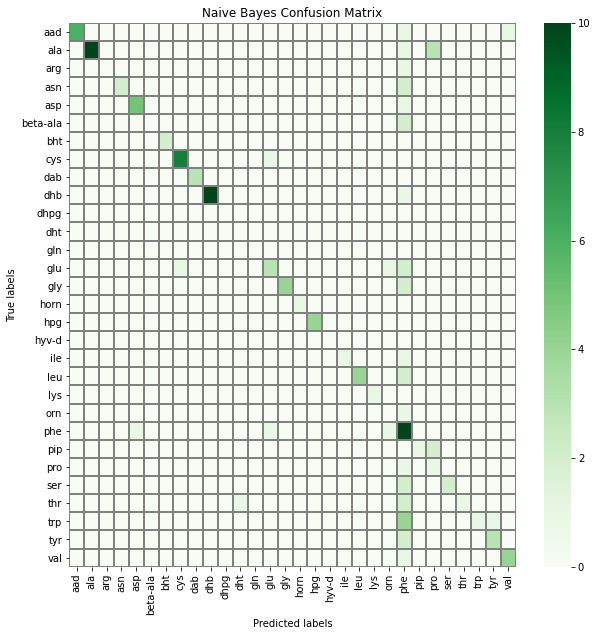

In [76]:
# Create a Gaussian classifier
nb_model = GaussianNB()

kf = KFold(n_splits=10)
results = cross_val_score(nb_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
                                                    np.std(results)))
print('===================')

nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))
print('Naive Bayes macro f1-score:', round(f1_score(y_test, nb_pred, average='macro'), 3))
print(classification_report(y_test, nb_model.predict(X_test)))

cm_nb = confusion_matrix(y_test, nb_pred, labels=labels)

k = 10
cm_nb[cm_nb > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_nb, ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey') 

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Naive Bayes Confusion Matrix') 

# Catboost

In [201]:
# cat = CatBoostClassifier()
# params = {  
#     "max_depth": [7],
#     "learning_rate": [0.4],
#     "iterations": [75]
# }

# search_cat = GridSearchCV(estimator=cat, param_grid = params, n_jobs=-1)
# kf = KFold(n_splits=10)
# results = cross_val_score(search_cat, X_train, y_train, cv=kf)
# print('Cross Validation accuracy scores: %s' % results)
# print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
#                                                     np.std(results)))
# print('===================')

# search_cat.fit(X_train, y_train)
# print(search_cat.best_params_)

# print(classification_report(y_test, search_cat.best_estimator_.predict(X_test)))

# Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Cross Validation accuracy scores: [0.90825688 0.87155963 0.8440367  0.85185185 0.87962963 0.82407407
 0.85185185 0.87962963 0.84259259 0.86111111]
Cross Validation accuracy: 0.861 +/- 0.023
Best Parameters:
 {'C': 3, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression accuracy: 0.9
Logistic Regression macro f1-score: 0.68
              precision    recall  f1-score   support

         aad       1.00      0.78      0.88         9
         ala       0.96      1.00      0.98       109
         asn       1.00      1.00      1.00         3
         asp       1.00      0.67      0.80         3
    beta-ala       0.00      0.00      0.00         0
         bht       1.00      1.00      1.00         1
         cys       0.78      1.00      0.88         7
         dab       1.00      1.00      1.00         2
         dhb       1.00      1.00      1.00        55
         gln       1.00      1.00      1.00         2
         glu       0.00      0.00      0.00         2
         gly       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


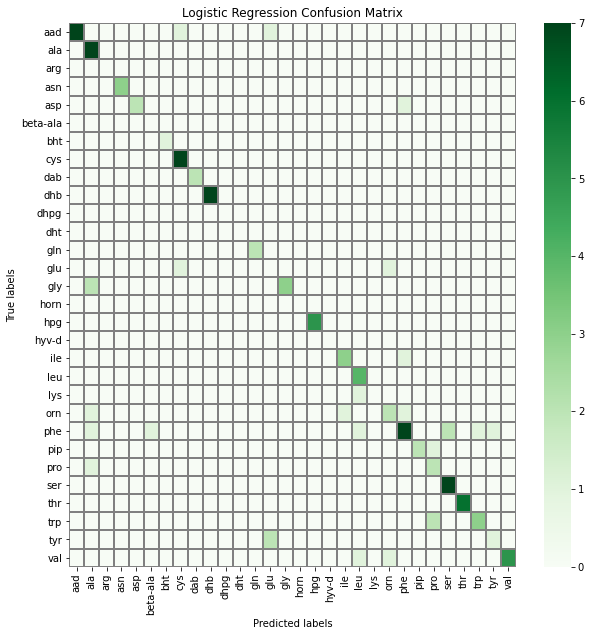

In [202]:
log_grid = {'C': [3], 
                 'penalty': ['l2'],
            'solver' : ['liblinear']
            }

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

kf = KFold(n_splits=10)
results = cross_val_score(log_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results), 
                                                    np.std(results)))
print('===================')


log_model.fit(X_train, y_train)

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test, log_pred), 3))
print('Logistic Regression macro f1-score:', round(f1_score(y_test, nb_pred, average='macro'), 3))
print(classification_report(y_test, best_log.predict(X_test)))

cm_log = confusion_matrix(y_test, log_pred, labels=labels)

k = 7
cm_log[cm_log > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_log, ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey') 

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Logistic Regression Confusion Matrix') 

# Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions.

Cross Validation accuracy scores: [0.88990826 0.85321101 0.80733945 0.81481481 0.84259259 0.80555556
 0.83333333 0.83333333 0.87037037 0.76851852]
Cross Validation accuracy: 0.832 +/- 0.033


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions.

Best Parameters:
 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.53, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 51, 'n_jobs': 20, 'warm_start': True}
Random Forest accuracy: 0.856
Random Forest f1-score: 0.608


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         aad       1.00      0.78      0.88         9
         ala       0.99      0.94      0.97       109
         arg       0.00      0.00      0.00         0
         asn       0.50      0.67      0.57         3
         asp       0.75      1.00      0.86         3
    beta-ala       0.00      0.00      0.00         0
         bht       1.00      1.00      1.00         1
         cys       0.78      1.00      0.88         7
         dab       1.00      1.00      1.00         2
         dhb       1.00      1.00      1.00        55
         dht       0.00      0.00      0.00         0
         gln       1.00      1.00      1.00         2
         glu       0.00      0.00      0.00         2
         gly       0.75      0.60      0.67         5
         hpg       1.00      1.00      1.00         5
         ile       0.75      0.75      0.75         4
         leu       0.50      1.00      0.67         4
         lys       0.00    

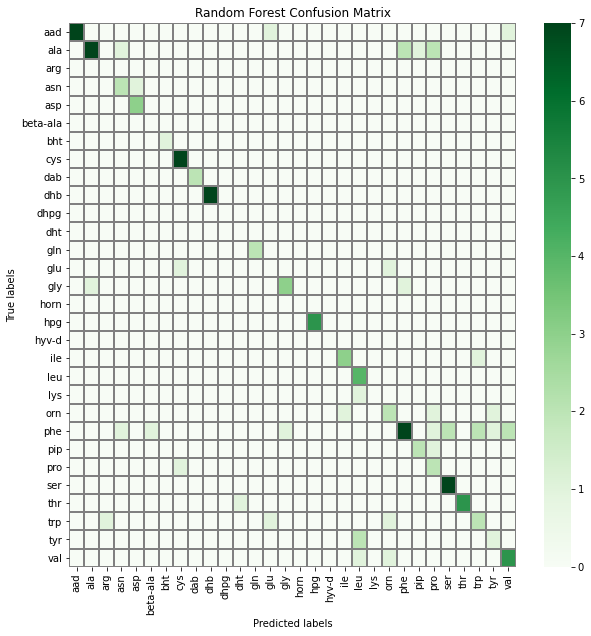

In [203]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [True],
         'n_estimators': [50],
         'max_features': [0.52],
         'min_samples_leaf': [3],
         'min_samples_split': [2],
         'class_weight' : ["balanced"],
                 'criterion' : ['entropy'],
                 'max_depth' : [10],
                 'n_jobs' : [20], 'warm_start' : [True]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')


kf = KFold(n_splits=10)
results = cross_val_score(rf_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))
print('Random Forest f1-score:', round(f1_score(y_test, rf_pred, average='macro'), 3))
print(classification_report(y_test, rf_model_best.predict(X_test)))

cm_rf = confusion_matrix(y_test, rf_pred, labels=labels)

k = 7
cm_rf[cm_rf > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_rf,  ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey')

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Random Forest Confusion Matrix') 

# Supporting Vector Machines

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Cross Validation accuracy scores: [0.83486239 0.85321101 0.88073394 0.88888889 0.85185185 0.84259259
 0.81481481 0.87962963 0.87962963 0.92592593]
Cross Validation accuracy: 0.865 +/- 0.030


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'poly'}
SVM accuracy: 0.867
SVM macro f1-score: 0.737


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         aad       1.00      0.62      0.77         8
         ala       0.98      0.99      0.99       119
         arg       1.00      1.00      1.00         1
         asn       1.00      0.50      0.67         4
         asp       0.83      0.83      0.83         6
    beta-ala       0.00      0.00      0.00         2
         bht       1.00      1.00      1.00         2
         cys       0.78      0.78      0.78         9
         dab       1.00      1.00      1.00         3
         dhb       1.00      0.98      0.99        43
         glu       0.60      0.43      0.50         7
         gly       1.00      0.83      0.91         6
        horn       1.00      1.00      1.00         1
         hpg       1.00      1.00      1.00         4
         ile       1.00      0.50      0.67         2
         leu       1.00      1.00      1.00         6
         lys       1.00      1.00      1.00         1
         orn       0.00    

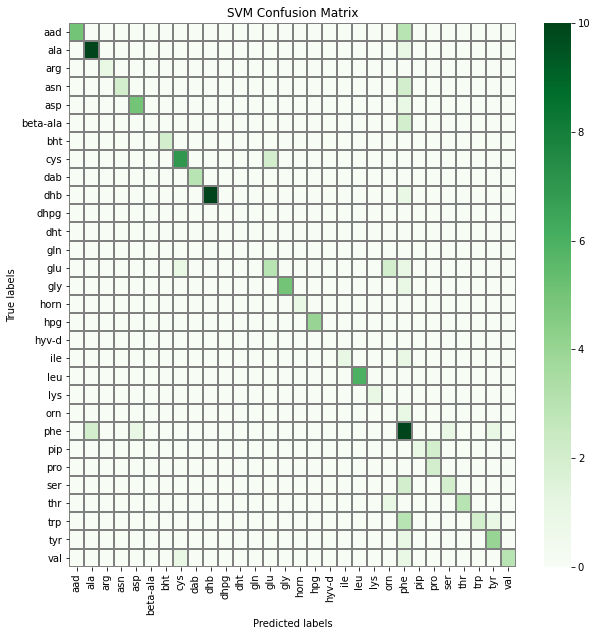

In [79]:
# Parameter grid
svm_param_grid = {'C': [0.1], 
                  'gamma': [0.1], 
                  "kernel": ["poly"], 
                  "decision_function_shape" : ["ovo"]
                  } 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

kf = KFold(n_splits=10)
results = cross_val_score(svm_grid, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')


# Train the classifier
svm_grid.fit(X_train, y_train)

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test)

print('SVM accuracy:', round(accuracy_score(y_test, svm_pred), 3))
print('SVM macro f1-score:', round(f1_score(y_test, svm_pred, average='macro'), 3))

print(classification_report(y_test, best_svc.predict(X_test)))

cm_svm = confusion_matrix(y_test, svm_pred, labels=labels)

k = 10
cm_svm[cm_svm > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_svm,  ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey')

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('SVM Confusion Matrix') 

In [1]:
# import csv

# with open("torsion-99sb-ildn.dat") as infile, open("outfile.csv", "w") as outfile:
#     csv_writer = csv.writer(outfile)
#     prev = ''
#     csv_writer.writerow(['ID', 'PARENT_ID'])
#     for line in infile.read().splitlines():
#         csv_writer.writerow([line, prev])
#         prev = line